# Face Recognition $\times$ K-Pop Part 1: Recognizing Twice (트와이스) Members

The research in face recognition has been a great success in recent years. For example, Facebook can suggest you tagging your photos by recognizing the face of your friends. There are web app comparing your face with celebrities.

There are many open source library available which made the face recognition very easy by just a few line of codes. Of course it will not be 100% accurate but you would agree it is fair for a machine with limited data available. 

So, let's start with something fun: **Recognizing [Twice](http://twice.jype.com/) members in an image!**

In this article, we wil be using python with [face_recognition](https://github.com/ageitgey/face_recognition) packages written by Adam Geigey which he introduces in his [article](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78). I recommend reading the article first as it will explain the technical details of face recognition process. We will also go through some Mathematics concept.

In [1]:
# First we load the library we use
%matplotlib inline 
import os                            # For accessing image path
import numpy as np                   # For numerical operation
import matplotlib.pyplot as plt      # For plotting
import matplotlib.patches as patches # For drawing
import scipy.misc as misc            # For reading image
import face_recognition              # For face recognition

## Loading the data

There are two pieces of data we will need:
1. [Pictures](http://twice.jype.com/profile.asp) of each Twice member and name the file as <NAME>.png
2. An untagged picture of twice captured in [Singal](https://www.youtube.com/watch?v=VQtonf1fv_s) MV.

Let's read and print the image first.

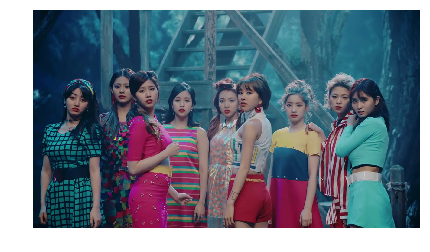

In [2]:
# Read untagged image
twice_image = misc.imread(os.path.join('..','input','image','twice','twice_signal_1.png'))

# Print the image
plt.figure(figsize=(11, 4))
plt.imshow(twice_image)
plt.axis('off')
plt.show()

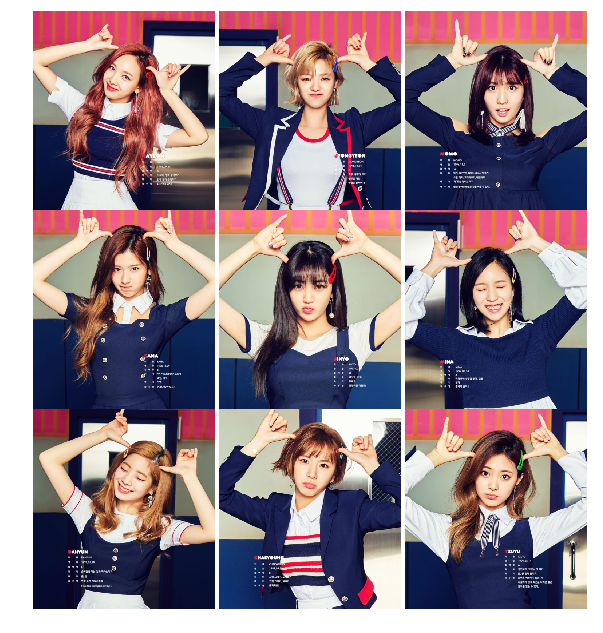

In [3]:
# Define name of Twice member
twice_members = ['NAYEON','JEONGYEON','MOMO','SANA','JIHYO','MINA','DAHYUN','CHAEYOUNG','TZUYU']
# Read personal image
twice_member_images = [misc.imread(os.path.join('..','input','face','twice',member+'.jpg')) for member in twice_members]

plt.figure(figsize=(10, 11))
for i in range(len(twice_members)):
    plt.subplot(3,3,i+1)
    plt.imshow(misc.imresize(twice_member_images[i], (550, 500)))
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Let's take a look at the know face image first. We can locate the face position by a single line of code.

In [4]:
twice_member_face_locations = [face_recognition.face_locations(img) for img in twice_member_images]

We can draw a box on the face location:

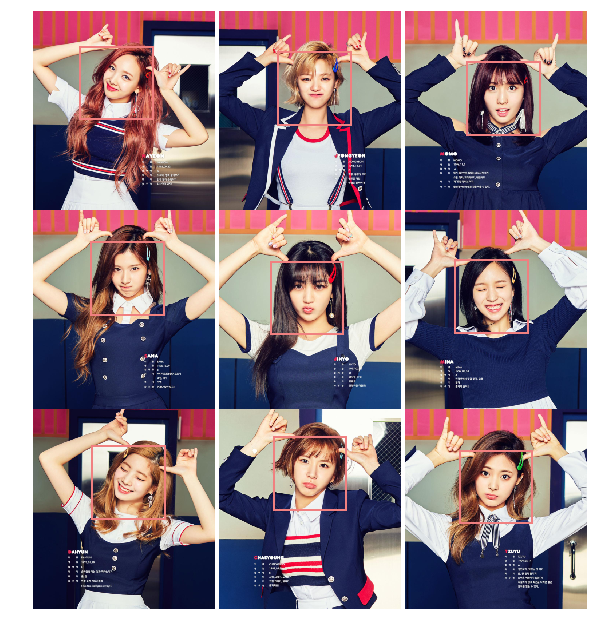

In [5]:
def show_faces(ax, image, face_locations, scale = 1.0, box_size = None):
    ax.imshow(misc.imresize(image, scale))
    ax.axis('off')
    
    # Show Face - Add rectange
    for face_location in face_locations:
        # Print the location of each face in this image
        top, right, bottom, left = face_location
        top = top * scale
        right = right * scale
        bottom = bottom * scale
        left = left * scale
        if box_size is not None:
            v_adjust = (box_size - (bottom - top)) / 2
            h_adjust = (box_size - (right - left)) / 2
            top -= v_adjust
            bottom += v_adjust
            right += h_adjust
            left -= h_adjust
        # print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
        rect = patches.Rectangle((left,top),right-left,bottom-top,linewidth=2,edgecolor='lightcoral',facecolor='none')
        ax.add_patch(rect)
        
fig, ax = plt.subplots(3, 3, figsize=(10, 11))
for i in range(len(twice_members)):
    show_faces(ax[i//3, i%3], twice_member_images[i], twice_member_face_locations[i], 0.5, 200)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Then, we will store the known face encoding in `twice_member_face_encodings`. Face encoding is a set of 128 numbers stored as a vector representing or discribing the face so that each person will have a different encoding. (You can also refer to this [article](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78) for details.)

In [6]:
twice_member_face_encodings = [face_recognition.face_encodings(image)[0] for image in twice_member_images]

The encoding system is a blackbox, we don't know what each number represent so it is not meaningful to look at the encoding 128 numbers. But we can still make use of the numbers to do some interpretation.

## Special: Who are the twins in Twice

Before face recogition, we can do something fun with the ecoded face. One example would be looking at *which two Twice members have the most similar face*. It will then become a Mathematics problam of finding the closest 128 dimension vector. The simpliest distance function is called [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance) which is the *square root of the sum of squared difference*. 

Now we can just compute the pairwise distance of those encoded images to see which two faces are the most similar.

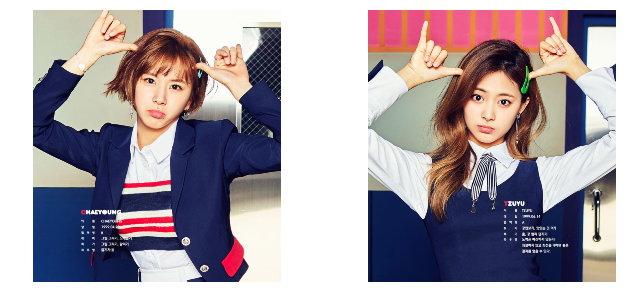

In [8]:
from scipy.spatial.distance import pdist, squareform
# The i-th row, j-column means the distance between the i-th member and j-th member
dist_matrix = squareform(pdist(twice_member_face_encodings)) 
# Get the min i and j
most_similar = np.unravel_index((dist_matrix + np.identity(9)).argmin(), dist_matrix.shape)
# Plot
plt.figure(figsize=(11, 5))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(misc.imresize(twice_member_images[most_similar[i]], 0.5))
    plt.axis('off')
plt.show()

The most similar face are CHAEYOUNG and TZUYU. Although the algorithm will do face landmark location before encoding you may still claim that it is because they have similar facial expression. We never know because machine learning is a blackbox and remember that the machine has only seen **ONE** image of them.

One drawback of the above method is that we cannot visualise how close of the face of each pair of members and the weight of each dimension is different which may introduce bias. We can use some dimension-reduction algorithm such as PCA and [TSNE](https://lvdmaaten.github.io/tsne/) which can help us the reduce the encoded image into 2-D space for plotting.

## Face Recogntion

Now, let's start our face recogntion.

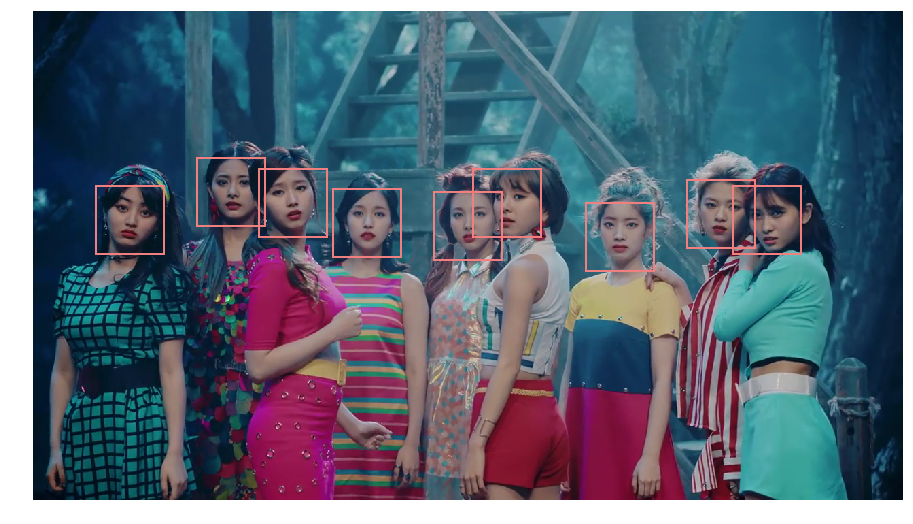

In [9]:
face_locations = face_recognition.face_locations(twice_image)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
show_faces(ax, twice_image, face_locations, box_size = 100)
plt.show()

Great. The Algorithm can spot all the faces in the images. The next step would be encoding the face into 128d vector and compare them with the known image.

In [10]:
face_encodings = face_recognition.face_encodings(twice_image, face_locations)

from sklearn.metrics.pairwise import euclidean_distances
# i-th row is the untagged face location
# j-th column is the known twice member face
dist = euclidean_distances(face_encodings, twice_member_face_encodings)

Now we assign each untagged to the cloest known face and print the result

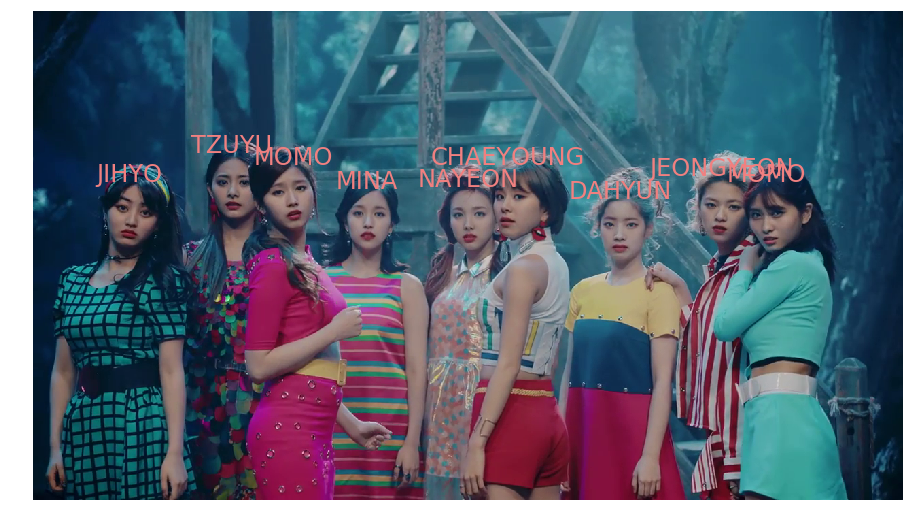

In [11]:
untagged_face_guess = np.argmin(dist, axis=1) # assign untagged face to closest known face
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.imshow(twice_image)
# show_faces(ax, twice_image, face_locations, box_size = 100)
for i in range(9):
    ax.text((face_locations[i][1] + face_locations[i][3]) / 2,
            face_locations[i][0] - 20,
            twice_members[untagged_face_guess[i]], 
            horizontalalignment='center',
            fontsize=24,color='lightcoral')
plt.axis('off')
plt.show()

It only wrongly classify SANA as MOMO. How can we improve it? For a machine learning model, one of the way is to give some extra information. Gathering more data (tagged image) could improve it but if you could notice there is a piece exisitng information we didn't provide.

That is: **each member appears in the photo once and only once.**

After we have the information, we can turn it as a Mathematical assignment problem. One way of solving it is to optimize the minimum of sum of distance between assigned face encoding and true face encoding. We can use optimization library in Scipy to do that.

In [12]:
from scipy.optimize import linear_sum_assignment
untagged_face_index, untagged_face_guess = linear_sum_assignment(np.array(dist))

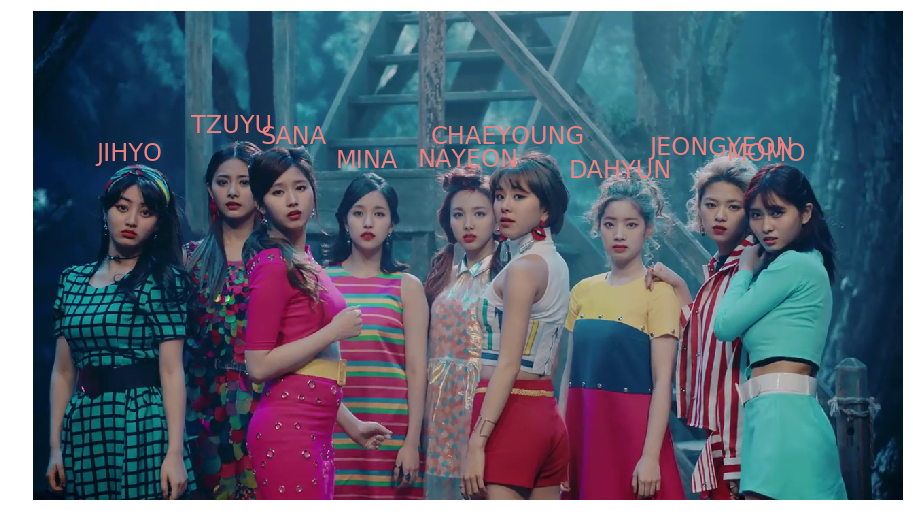

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.imshow(twice_image)
# show_faces(ax, twice_image, face_locations, box_size = 100)
for i in range(9):
    ax.text((face_locations[i][1] + face_locations[i][3]) / 2,
            face_locations[i][0] - 50,
            twice_members[untagged_face_guess[i]], 
            horizontalalignment='center',
            fontsize=24,color='lightcoral')
plt.axis('off')
plt.show()

Boom! The machine correctly recognized Twice members!

## Summary

- We used Python face_recognition library to recognize Twice members within a few lines
- Considering the model only see their image once and it is not trained specifically for Asian, the performance is actually pretty good
- Remember the more information we have, the higher accuracy we are
- We could always collect more data but sometimes using existing info is already sufficient

In next article, we will be playing with [BLACKPINK](https://en.wikipedia.org/wiki/Black_Pink) lastest MV [마지막처럼 (AS IF IT'S YOUR LAST)](https://www.youtube.com/watch?v=Amq-qlqbjYA). Blink fans stay tuned!